In [1]:
%matplotlib inline
import rebound
import os
import numpy as np
import datetime
import corner
import astropy
from astropy.time import Time
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
event = Time("2013-02-15 03:20:21.1", format="iso", scale="utc")
aa_frame = AltAz(location=EarthLocation(lat=54.4540*u.deg,lon= 64.4739*u.deg), obstime=event)
up = SkyCoord('0deg 90deg',frame=aa_frame, unit=u.deg).transform_to("icrs")
east = SkyCoord('90deg 0deg',frame=aa_frame, unit=u.deg).transform_to("icrs")
ura, udec = up.ra.value, up.dec.value
era, edec = east.ra.value, east.dec.value

In [10]:
def radec2xyz(ra, dec):
    x = np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.sin(np.pi/180.*dec)
    return np.array([x, y, z])
    
def mod360(a):
    while a>360.:
        a-=360.
    while a<0.:
        a+=360.
    return a

def run(params):
    randfac = 0.
    sim = rebound.Simulation.from_file("ss_frame.bin")
    #sim.Nactive = sim.N
    p = sim.particles[3].copy()
    p.m = 0.

    #Relative velocity to atmosphere 
    v = (19.03+0.13*randfac*np.random.normal())*0.033572943
    vx, vy, vz = -v*radec2xyz(328.12+0.10*randfac*np.random.normal(),7.41+0.05*randfac*np.random.normal())
    p.vx += vx; p.vy += vy; p.vz += vz    
    
    #atmosphere velocity relative to Earth
    vx, vy, vz = +0.27411473*0.033572943*radec2xyz(era,edec)
    p.vx += vx; p.vy += vy; p.vz += vz

    #Location + 95km
    r = 4.2587571e-05 + 6.3503578e-07
    x, y, z = r*radec2xyz(ura, udec)
    p.x += x; p.y += y; p.z += z    

    sim.add(p)
    sim.move_to_com()
    sim.ri_ias15.min_dt = 1e-6
    
    sim.integrate(-1.)
    
    simo = sim
    sim = rebound.Simulation()
    for i in range(simo.N):
        if i==3:
            continue
        elif i==4:
            com = (simo.particles[3]*simo.particles[3].m + simo.particles[4]*simo.particles[4].m)/(simo.particles[3].m+simo.particles[4].m)
            sim.add(com)
        else:
            sim.add(simo.particles[i])
    #sim.save("test.bin")
  
            
    sim.integrator = "whfast"
    sim.dt = -sim.particles[1].P*0.01234
    N=10000
    samples = np.zeros((N,6))
    times = np.linspace(0.,-1e3,N)
    for i,t in enumerate(times):
        #print(t)
        sim.integrate(t)
        o = sim.particles[7].calculate_orbit(primary = sim.particles[0])

        sim.status()
        sim.particles[1].xyz = [0.,1.,2.]
        sim.status()
        return
        
        samples[i] = [t] + sim.particles[7].xyz + [o.a,o.e]
    
    return samples


In [11]:
samples2 = run(1)

---------------------------------
REBOUND version:     	2.14.4
REBOUND built on:    	Apr 26 2016 13:38:26
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	0.000000
Current timestep:    	-0.018674
---------------------------------
<rebound.Particle object, id=0 m=1.0 x=0.0008691590857915625 y=-0.002767439610438327 z=-0.001273809435932194 vx=0.00035927422927055597 vy=-5.772172567372092e-05 vz=-3.351501770278373e-05>
<rebound.Particle object, id=0 m=1.6601141530543485e-07 x=-0.3695290951531342 y=-0.2115808706313901 z=-0.07441610439873418 vx=0.501151914104728 vy=-1.1616483867740868 vz=-0.6724554551835523>
<rebound.Particle object, id=0 m=2.4478382877847715e-06 x=-0.6259780344016538 y=-0.34313461471080076 z=-0.11474781353527085 vx=0.5745784608555009 vy=-0.9234853079079723 vz=-0.45184622266333097>
<rebound.Particle object, id=0 m=2.9674443406827916e-06 x=0.04696624261612864 y=0.8989610379916492 z=0.3896405943675714 vx=-1.0149664471045634 vy=0.03952221678018538 vz=0.

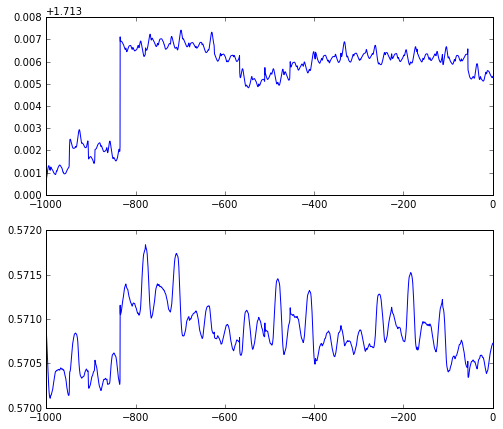

In [8]:
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(211)
ax.plot(samples2[:,0],samples2[:,4])
ax = plt.subplot(212)
ax.plot(samples2[:,0],samples2[:,5])

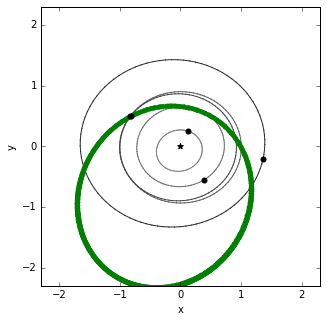

In [9]:
sim = rebound.Simulation.from_file("ss_frame.bin")
f = rebound.OrbitPlot(sim,lim=2.3);
#f.axes[0].plot(samples[:,0],samples[:,1],"r",alpha=0.7)
f.axes[0].plot(samples2[:,1],samples2[:,2],"g.",alpha=0.7)

In [32]:
print(1)

1
